# Skill Validation

In this notebook, we aim to calibrate and validate the Ilha Grande Bay's model, by comparing the sea level elevation measured in situ, by BNDO/Brazilian's Navy, with the output data from the UPOM (Urban Physical Ocean Modelling)


## Part 1
In the first part of this notebook, we'll find, read and process the observed data, given by BNDO in personal contact.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.spatial import cKDTree
import glob
import xray as xr
import os
import string

import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline

# importando meu pacote de funções
import sys

sys.path.append('../rotinas/artigoTGpack/')

import artigoTGpack as oceano

In [2]:
BASE_DIR = oceano.make_dir()

DATA_DIR = BASE_DIR.replace('github/','artigo_data/BNDO/')
SIMS_DIR = BASE_DIR.replace('github/','/artigo_data/simulacoes/')

SIMS_DIR

'/home/tparente/danilo/mestrado//artigo_data/simulacoes/'

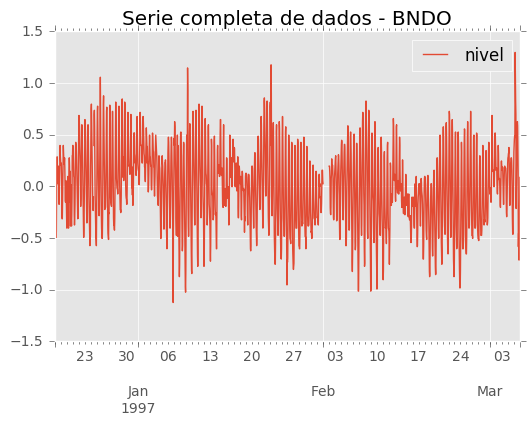

In [3]:
lfiles = glob.glob(DATA_DIR+'1997/*')
lfiles.sort()

# ler, inicialmente, os dois primeiros arquivos para ampliar uma série
files = lfiles[:2]

file1 = pd.read_csv(files[0], skiprows=11, delimiter=';', names=['nivel', 'x'])
file1.drop(file1.columns[len(file1.columns)-1], axis=1, inplace=True)

file2 = pd.read_csv(files[1], skiprows=11, delimiter=';', names=['nivel', 'x'])
file2.drop(file2.columns[len(file2.columns)-1], axis=1, inplace=True)

# criar os dataframes
dtRange = pd.date_range(start=file1.index[0], end=file1.index[-1], freq='H')
df1 = pd.DataFrame({'nivel': file1['nivel'].values/100.}, index=dtRange)

dtRange = pd.date_range(start="1997-02-02 00:00", end="1997-03-05 23:00", freq='H')
df2 = pd.DataFrame({'nivel': file2['nivel'].values/100.}, index=dtRange)

dtRange = pd.date_range(start='1997-02-01 00:00', end='1997-02-01 23:00', freq='H')
df3 = pd.DataFrame({'nivel': np.ones(dtRange.shape[0])*np.nan}, index=dtRange)

# concatenar as séries
observ = pd.concat([df1, df3, df2])

# controle de qualidade
cond = observ['nivel'] > 4.
observ[cond] = np.nan

# removendo a média da série temporal
observ['nivel'] = observ['nivel'] - observ['nivel'].mean()

observ.plot(title='Serie completa de dados - BNDO')

In [4]:
# checar os extremos da série para verificar: data e valor
print('Primeiro registro: ')
print(observ.head())
print('-------------------')
print('Último registro: ')
print(observ.tail())

Primeiro registro: 
                        nivel
1996-12-18 00:00:00 -0.004624
1996-12-18 01:00:00  0.095376
1996-12-18 02:00:00  0.085376
1996-12-18 03:00:00 -0.104624
1996-12-18 04:00:00 -0.304624
-------------------
Último registro: 
                        nivel
1997-03-05 19:00:00 -0.704624
1997-03-05 20:00:00 -0.714624
1997-03-05 21:00:00 -0.504624
1997-03-05 22:00:00 -0.184624
1997-03-05 23:00:00  0.085376


In [5]:
# determinando a média dos dados, para sair de dados horários, para o valor
# de saída do modelo.

# em caso de modelo com frequência horária, não realizar o resample

# resample para alterar frequência para 6 em 6 horas
# observ = observ['1996-12-18 01:00:00':].resample('5H').mean()

# loop para remover os valores em horários que não desejo
# hours = [3, 9, 15, 21]

# dado = []
# time = []
# for i in np.arange(len(obs)):
#     if obs.index.hour[i] in hours:
#         dado.append(obs.nivel[i])
#         time.append(obs.index[i])

# # converter para dataframe
# observ = pd.DataFrame({'nivel':dado},index=time)
# observ.tail()

####### POG #######
# obs = observ['1997-01-06 01:00':'1997-02-09 21:00'] # cut the data

# ind = obs.index.values
# obs['new'] = np.arange(0,len(obs.index))

# obs.set_index('new',drop=True,inplace=True)
# obs['time'] = ind

# obs.head()


In [6]:
# POOOOOOG

# dados = []
# time  = []

# for i in np.arange(2,len(ind),5):
#     dataMean = np.nanmean(obs.nivel[i:i+4])
#     dados.append(dataMean)
#     time.append(obs.time[i-1])
# #     dados.append(observ.nivel[i])
# #     time.append(observ.time[i])

# observ = pd.DataFrame({'nivel':dados}, index=time)
# observ

#### a little description about average and the frequency in the observed data

So far, we have processed the observed data, creating a single dataframe with hourly observation of sea level elevation (observ)

These data are in a hourly frequency, since 18/12/1996 00h until 05/03/1997 23h. To compare with the output's model, we need to maintain a consistency in the datetime. 

We need to verify, in the gcmplt.cdf, which frequency the model's output are.

Above, we calculate a resample, taking the 5 hour average.


## Part 2

Secondly, we'll read and process the modeled data.


In [7]:
# importar grade do modelo
ncfile = xr.open_dataset(SIMS_DIR+'mare6h/gcmplt.cdf')

lon = ncfile['lon'].data
lat = ncfile['lat'].data

lon[lon == 0.0] = np.nan
lat[lon == 0.0] = np.nan

# localizacao do terminal da ilha guaiba

ilat = -23.00000000
ilon = -44.01916667


lo = lon.ravel()
la = lat.ravel()

coords = []

for i,j in zip(la,lo):
    coords.append([i,j])

coords = np.array(coords)

locations_name = ['Terminal Ilha Guaiba']
locations_posi = [[ilat,ilon]]

locs = np.asarray(locations_posi)

tree = cKDTree(coords)
# procura em tree os pontos mais próximos dos pontos definidos acima
dists,indexes = tree.query(locs,k=1)

pontos = []

for index in indexes:
    pontos.append(coords[index])

# converter de lista para array
pontos = np.asarray(pontos)

# findind indexes from lat and lon
ind = []

for p in pontos:
    ind.append(np.where(lon == p[1]))

ind = np.asarray(ind)

# vetores para separar i e j para facilitar resgatar os dados de concentração
iss=[]
jss=[]

for i,j in ind:
    iss.append(int(i))
    jss.append(int(j))
    
iss,jss

([193], [26])

In [8]:
time = ncfile['time'].values # data from 1997-01-06 00h onwards

time.shape

(164,)

In [9]:
# import output data
elev = ncfile['elev'].data[:,iss,jss]
elev = np.squeeze(elev)

print(elev.shape)

# time = ncfile['time'][68:247] # 1997-01-31 23:00:00
time = ncfile['time'][:].values
print(time[-1])

# criar dataframe
model = pd.DataFrame({'modeled':elev}, index=time)

# model['1997-01-06 00:00':].shape
model

(164,)
1997-01-10T21:00:00.000000000


,modeled
1996-12-01 03:00:00,-0.172440
1996-12-01 09:00:00,0.209980
1996-12-01 15:00:00,-0.085152
1996-12-01 21:00:00,0.055852
1996-12-02 03:00:00,-0.156875
1996-12-02 09:00:00,0.094613
1996-12-02 15:00:00,-0.016176
1996-12-02 21:00:00,0.000305
1996-12-03 03:00:00,-0.061041
1996-12-03 09:00:00,-0.009156


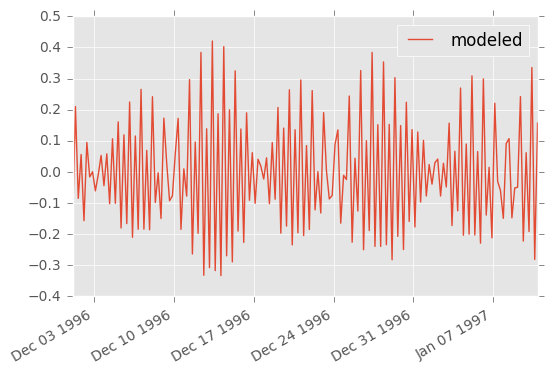

In [10]:
model.plot()

In [11]:
# dateRange para selecionar os dados
dtRange = pd.date_range(start=time[0],end=time[-1], freq='18359s')
dtRange

DatetimeIndex(['1996-12-01 03:00:00', '1996-12-01 08:05:59',
               '1996-12-01 13:11:58', '1996-12-01 18:17:57',
               '1996-12-01 23:23:56', '1996-12-02 04:29:55',
               '1996-12-02 09:35:54', '1996-12-02 14:41:53',
               '1996-12-02 19:47:52', '1996-12-03 00:53:51',
               ...
               '1997-01-08 19:08:58', '1997-01-09 00:14:57',
               '1997-01-09 05:20:56', '1997-01-09 10:26:55',
               '1997-01-09 15:32:54', '1997-01-09 20:38:53',
               '1997-01-10 01:44:52', '1997-01-10 06:50:51',
               '1997-01-10 11:56:50', '1997-01-10 17:02:49'],
              dtype='datetime64[ns]', length=192, freq='18359S')

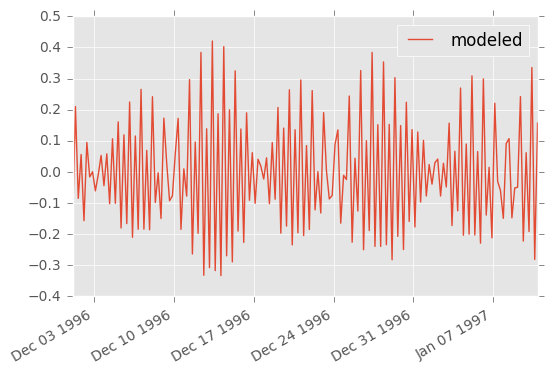

In [12]:
model.plot()

## Part 3

Finally, put it all together!

In [13]:
# check size of observed data, considering only the period we want to 
# validate

observ.index.shape, model.index.shape

((1872,), (164,))

In [14]:
# separar os indices dos dados que eu quero que index.hour sejam iguais
# observ[ observ.index.hour == model.index.hour ]

In [15]:
model.head()

,modeled
1996-12-01 03:00:00,-0.172440
1996-12-01 09:00:00,0.209980
1996-12-01 15:00:00,-0.085152
1996-12-01 21:00:00,0.055852
1996-12-02 03:00:00,-0.156875


In [16]:
tm = model.index
to = observ['1997-01-05 02:00':'1997-02-09 19:00'].index

modelTimestamp = []

for i in tm:
    modelTimestamp.append(pd.Timestamp(i).to_julian_date())

observTimestamp = []

for i in to:
    observTimestamp.append(pd.Timestamp(i).to_julian_date())
    
modelTimestamp  = np.asarray(modelTimestamp) 
observTimestamp = np.asarray(observTimestamp)

# search for the closest values between model and observTimestamp
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

indices = []

for i in modelTimestamp:
    indices.append(find_nearest(observTimestamp, i))

indices = np.asarray(indices)

ob=observ
ob['ind'] = np.arange(0,len(observ))
ob['datetime'] = observ.index.values
ob.set_index('ind', inplace=True)

# selected
n = []
for i in indices:
    value = ob[ob.index == i].nivel.values
    n.append(value)

n = np.asarray(n)

n = np.squeeze(n)

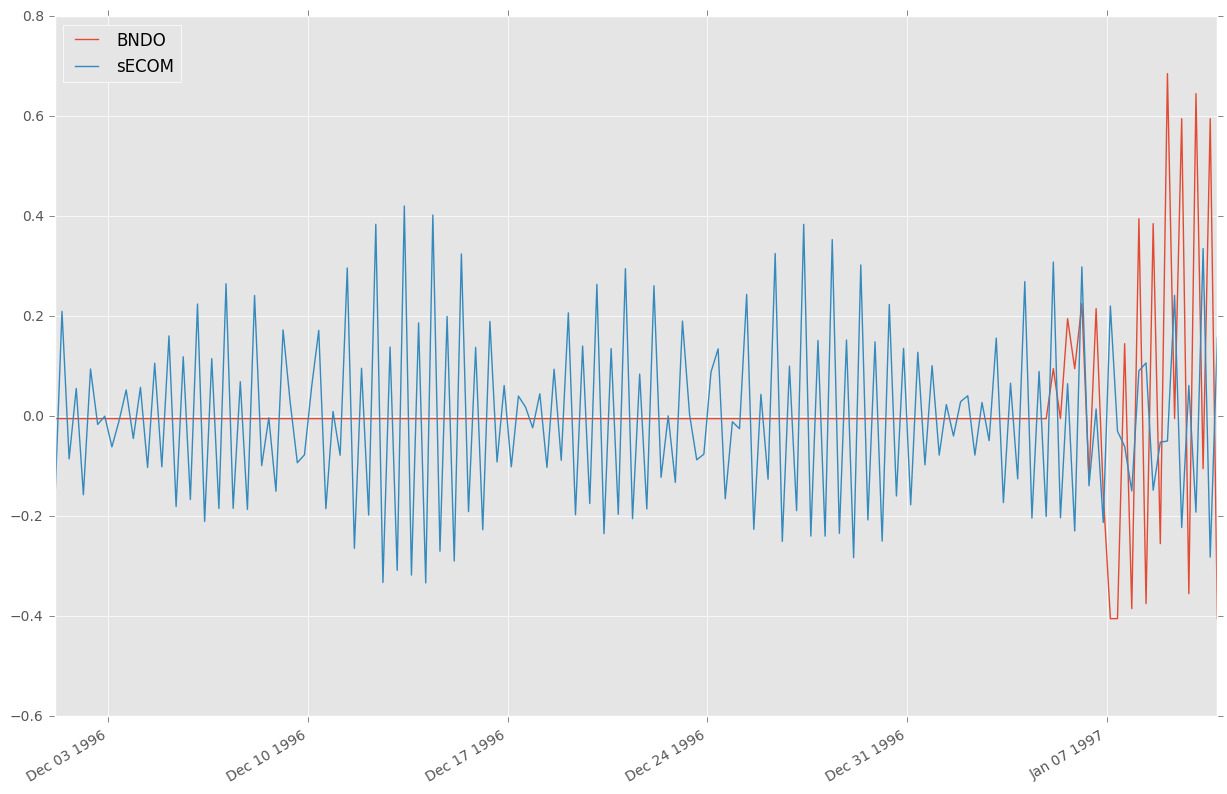

In [18]:
df = pd.DataFrame({
    'sECOM': model.modeled.values,
    'BNDO': n
}, index = model.index.values)

df.plot(figsize=(15,10))

# plt.savefog()

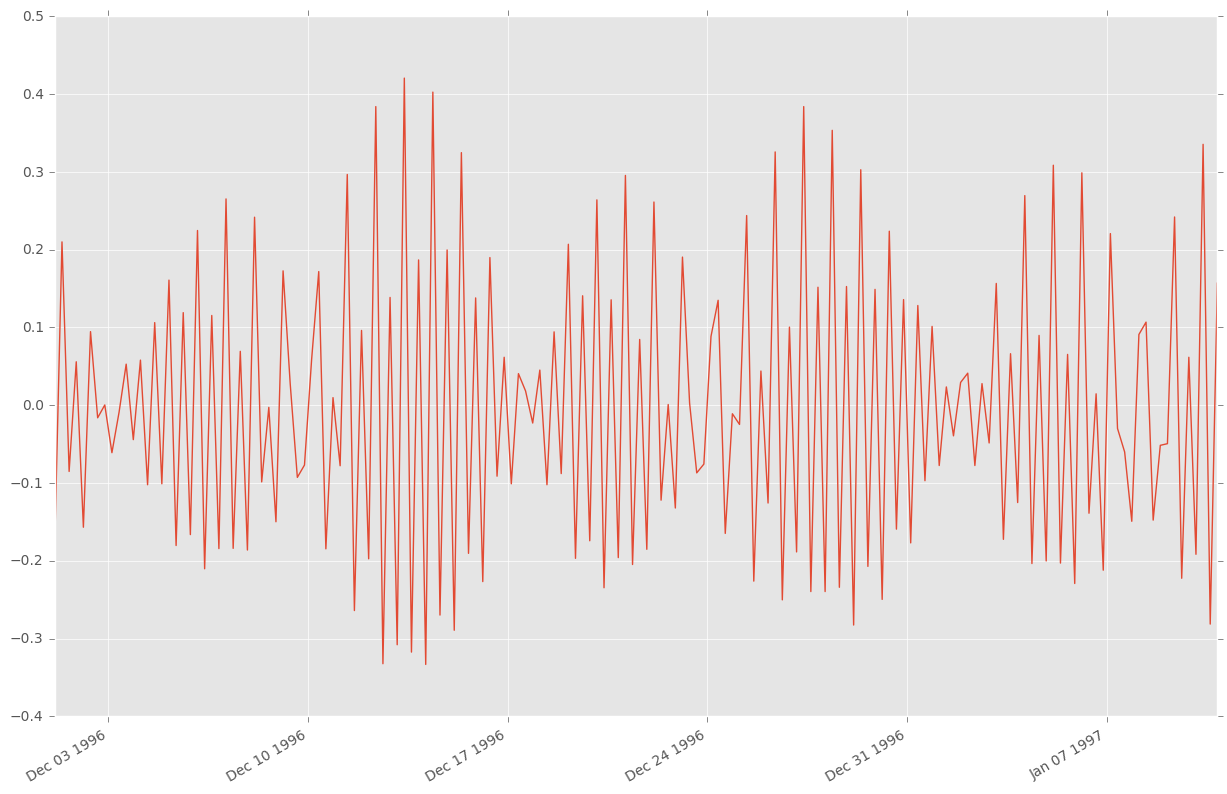

In [19]:
df.sECOM.plot(figsize=(15,10))

In [20]:

print(df.corr())

oceano.skill_willmott(df.BNDO.values, df.sECOM.values)

           BNDO     sECOM
BNDO   1.000000 -0.123431
sECOM -0.123431  1.000000


0.13699316116814875

# Filtrando o sinal da maré

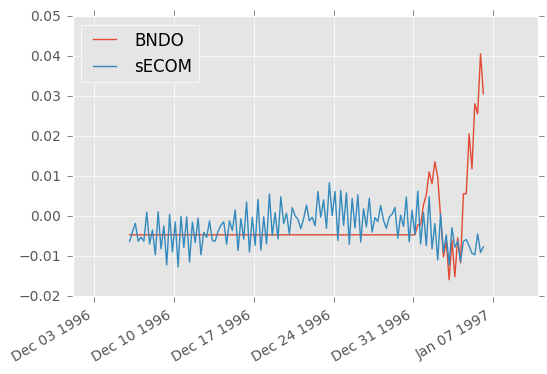

In [21]:
m=df['sECOM'].rolling(40, center=True).mean()
o=df['BNDO'].rolling(40, center=True).mean()

newdf = pd.DataFrame({'BNDO':o,'sECOM':m},index=df.index)

newdf.plot()

In [22]:
oceano.skill_willmott(newdf.BNDO.values, newdf.sECOM.values)

0.21721044797654931